#  SARII2 - Aitextgen


In [ ]:
import PIL
import textwrap
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw

In [ ]:
import urllib.request
from wasabi import msg
import random
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import spacy
from collections import Counter
from string import punctuation
from spacy import displacy
import en_core_web_md

In [ ]:
!pip install -q aitextgen

import logging
logging.basicConfig(
        format="%(asctime)s — %(levelname)s — %(name)s — %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO
    )

from aitextgen import aitextgen

In [ ]:
!jupyter nbextension enable --py widgetsnbextension

## GPU

Colaboratory uses a Nvidia P4, an Nvidia T4, an Nvidia P100, or an Nvidia V100. For finetuning GPT-2 124M, any of these GPUs will be fine, but for text generation, a T4 or a P100 is ideal since they have more VRAM. **If you receive a T4 or a V100 GPU, you can enable `fp16=True` during training for faster/more memory efficient training.**

You can verify which GPU is active by running the cell below. If you want to try for a different GPU, go to **Runtime -> Factory Reset Runtime**.

In [ ]:
!nvidia-smi

## Loading GPT-2 or GPT Neo

If you're retraining a model on new text, you need to download and load the GPT-2 model into the GPU. 

There are several sizes of GPT-2:

* `124M` (default): the "small" model, 500MB on disk.
* `355M` (default): the "medium" model, 1.5GB on disk.
* `774M` (default): the "large" model, 3GB on disk.

In [ ]:
#ai = aitextgen(tf_gpt2="124M", to_gpu=True)

ai = aitextgen(model="EleutherAI/gpt-neo-125M", to_gpu=True)

In [ ]:
file_name = "data/allquotes2.csv"

In [ ]:
df = pd.read_csv(file_name,header=None)

In [ ]:
df.head()

## Finetune GPT-2

The next cell will start the actual finetuning of GPT-2 in aitextgen. It runs for `num_steps`, and a progress bar will appear to show training progress, current loss (the lower the better the model), and average loss (to give a sense on loss trajectory).

The model will be saved every `save_every` steps in `trained_model` by default, and when training completes. If you mounted your Google Drive, the model will _also_ be saved there in a unique folder.

The training might time out after 4ish hours; if you did not mount to Google Drive, make sure you end training and save the results so you don't lose them! (if this happens frequently, you may want to consider using [Colab Pro](https://colab.research.google.com/signup))

Important parameters for `train()`:

- **`line_by_line`**: Set this to `True` if the input text file is a single-column CSV, with one record per row. aitextgen will automatically process it optimally.
- **`from_cache`**: If you compressed your dataset locally (as noted in the previous section) and are using that cache file, set this to `True`.
- **`num_steps`**: Number of steps to train the model for.
- **`generate_every`**: Interval of steps to generate example text from the model; good for qualitatively validating training.
- **`save_every`**: Interval of steps to save the model: the model will be saved in the VM to `/trained_model`.
- **`save_gdrive`**: Set this to `True` to copy the model to a unique folder in your Google Drive, if you have mounted it in the earlier cells
- **`fp16`**: Enables half-precision training for faster/more memory-efficient training. Only works on a T4 or V100 GPU.

Here are other important parameters for `train()` that are useful but you likely do not need to change.

- **`learning_rate`**: Learning rate of the model training.
- **`batch_size`**: Batch size of the model training; setting it too high will cause the GPU to go OOM. (if using `fp16`, you can increase the batch size more safely)

In [ ]:
ai.train(file_name,
         line_by_line=True,
         from_cache=False,
         num_steps=4000,
         generate_every=500,
         save_every=1000,
         learning_rate=1e-3,
         fp16=False,
         batch_size=1, 
         )

## Generate Text From The Trained Model

After you've trained the model or loaded a retrained model from checkpoint, you can now generate text.

**If you just trained a model**, you'll get much faster training performance if you reload the model; the next cell will reload the model you just trained from the `trained_model` folder.

In [ ]:
ai = aitextgen(model_folder="trained_model", to_gpu=True)

If you're creating an API based on your model and need to pass the generated text elsewhere, you can do `text = ai.generate_one()`

You can also pass in a `prompt` to the generate function to force the text to start with a given character sequence and generate text from there (good if you add an indicator when the text starts).

You can also generate multiple texts at a time by specifing `n`. You can pass a `batch_size` to generate multiple samples in parallel, giving a massive speedup (in Colaboratory, set a maximum of 50 for `batch_size` to avoid going OOM).

Other optional-but-helpful parameters for `ai.generate()` and friends:

*  **`min length`**: The minimum length of the generated text: if the text is shorter than this value after cleanup, aitextgen will generate another one.
*  **`max_length`**: Number of tokens to generate (default 256, you can generate up to 1024 tokens with GPT-2 and 2048 with GPT Neo)
* **`temperature`**: The higher the temperature, the crazier the text (default 0.7, recommended to keep between 0.7 and 1.0)
* **`top_k`**: Limits the generated guesses to the top *k* guesses (default 0 which disables the behavior; if the generated output is super crazy, you may want to set `top_k=40`)
* **`top_p`**: Nucleus sampling: limits the generated guesses to a cumulative probability. (gets good results on a dataset with `top_p=0.9`)

In [ ]:
def generatequote():    
    message = ai.generate_one(max_length=25,temperature=random.uniform(0.7, 1))
    message = message.replace("”","").replace("“","").replace("�","").replace('"',"")
    message = message.split(". ")[0]
    if not message[-1] == ".":
        message+="."
    message = "“" + message + "”"
    msg.good("Message")
    return message

In [ ]:
nlp = en_core_web_md.load()

In [ ]:
def get_key(text):
    result = []
    pos_tag = ['PROPN', 'ADJ', 'NOUN'] # 1
    doc = nlp(text.lower()) # 2
    for token in doc:
        # 3
        if(token.text in nlp.Defaults.stop_words or token.text in punctuation):
            continue
        # 4
        if(token.pos_ in pos_tag):
            result.append(token.text)
    msg.good("Keys Extracted")
    return list(set(result)) # 5

In [ ]:
message = generatequote()
print(message)
key = get_key(message)
print(key)

In [ ]:
def text2image(imageFile,font,quote):
    
    font = ImageFont.truetype(font, 75)

    para = textwrap.wrap(quote, width=42)

    MAX_W, MAX_H = 1080, 1080

    im = Image.open(imageFile).convert('RGBA')

    poly = Image.new('RGBA', (MAX_W,MAX_H))
    polydraw = ImageDraw.Draw(poly)

    polydraw.rectangle([(0,0),(MAX_W,MAX_H)], fill=(0,0,0,66), outline=None)
    
    im.paste(poly,mask=poly)

    draw = ImageDraw.Draw(im)

    current_h, pad = 370, 10

    for line in para:
        w, h = draw.textsize(line, font=font)
        draw.text(((MAX_W - w) / 2, current_h), line, font=font)
        current_h += h + pad
        
    current_h3, pad3 = 650, 10
    sitelink = " - sarii"
    w, h = draw.textsize(sitelink, font=font)
    draw.text(((MAX_W - w) / 2, current_h3), sitelink, font=font)
    current_h3 += h + pad3

    plt.imshow(np.asarray(im))
    name = list(quote.split())[1:5]
    newfilename = "".join(name)+".png"
    finalpath = "generated/"+newfilename
    im.save(finalpath)
    msg.good("Image Saved")
    return(finalpath)

In [ ]:
def downloadimage(key):
    imagepath = urllib.request.urlretrieve('https://source.unsplash.com/1080x1080/?'+str(key),"temp.jpg")[0]
    msg.good("Image Downloaded")
    return imagepath

In [ ]:
def selectfont():
    fonts = []
    os.chdir("fonts")
    for file in glob.glob("*.ttf"):
        fonts.append("fonts/"+file)
    os.chdir("..")
    msg.good("Font selected")
    return random.choice(fonts)

In [ ]:
def generate(message=None): 
    print('')
    if message == None:
        message = generatequote()
    try:
        keys = get_key(message)[:3]
        key = 'landscapes'
    except:
        msg.fail("Unable to retrieve key")
    imagepath = downloadimage(key)
    selectedfont = selectfont() 
    restultimage = text2image(imagepath,selectedfont,message)
    print('')
    msg.good("Done!")
    print('')
    msg.info("Image key: "+key)
    msg.info("Selected font: "+selectedfont)
    msg.info("Image path: "+restultimage)
    print('')
    print(message+' - #SARII #AI '+''.join(['#'+str(i.capitalize())+' ' for i in keys]))
    print('')

In [ ]:
!mkdir generated

In [ ]:
!rm -R generated && mkdir generated


✔ Message
✔ Keys Extracted
✔ Image Downloaded
✔ Font selected
✔ Image Saved

✔ Done!

ℹ Image key: landscapes
ℹ Selected font: fonts/Little Miracles Demo.ttf
ℹ Image path: generated/isgreatchangeto.png

“There is great change to be experienced once you learn the power of letting go.” - #SARII #AI #Change #Great #Power 



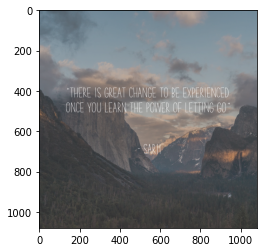

In [501]:
generate()